In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

from qiskit.aqua import QuantumInstance
from qiskit import BasicAer
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE, IQPE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import ExcitationPreserving

from qiskit.circuit.library import ExcitationPreserving

from qiskit import BasicAer
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.core import TransformationType, QubitMappingType
from qiskit.aqua.algorithms import VQAlgorithm, VQE, MinimumEigensolver
from qiskit.chemistry.transformations import FermionicTransformation
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.chemistry.algorithms.pes_samplers.extrapolator import *
from qiskit.chemistry.algorithms.pes_samplers.bopes_sampler import BOPESSampler
from qiskit.chemistry.drivers.molecule import Molecule
from qiskit.chemistry.algorithms.pes_samplers.potentials.energy_surface_spline import EnergySurface1DSpline
from thermodynamics.thermodynamics import constant_volume_heat_capacity
from thermodynamics.vibronic_structure_fd import VibronicStructure1DFD


import warnings
warnings.simplefilter('ignore', np.RankWarning)

ModuleNotFoundError: No module named 'partition_function'

To compute thermodynamic observables we begin with single point energy calculation which calculates the wavefunction and charge density and therefore  the energy of a particular arrangement of nuclei. Here we  compute the Born-Oppenheimer potential energy surface of a hydrogen molecule, as an example, which is simply the electronic energy as a function of bond length. 

In [3]:
ft = FermionicTransformation()
driver = PySCFDriver()
solver = VQE(quantum_instance=
             QuantumInstance(backend=BasicAer.get_backend('statevector_simulator')))
me_gsc = GroundStateEigensolver(ft, solver)

In [32]:
stretch1 = partial(Molecule.absolute_stretching, atom_pair=(1, 0))
mol = Molecule(geometry=[('H', [0., 0., 0.]),
                        ('H', [0., 0., 0.3])],
                       degrees_of_freedom=[stretch1],
                       masses=[1.6735328E-27, 1.6735328E-27]
                       )


# pass molecule to PSYCF driver
driver = PySCFDriver(molecule=mol)

In [33]:
# BOPES sampler testing
bs = BOPESSampler(gsc=me_gsc, 
                  bootstrap=True)
points = np.linspace(0.1,3,8)
res = bs.sample(driver,points)

In [36]:
energies = []
energies_extr = []
bs_res_full = res.raw_results
bs_res_full_extr = res_extr.raw_results
for point in points:
    energy = bs_res_full[point]['computed_electronic_energy'] + bs_res_full[point]['nuclear_repulsion_energy']
    energy_extr = bs_res_full_extr[point]['computed_electronic_energy'] + bs_res_full_extr[point]['nuclear_repulsion_energy']
    energies.append(energy)
    energies_extr.append(energy_extr)

Text(0, 0.5, 'Energy')

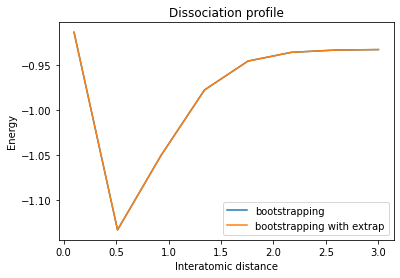

In [37]:
fig = plt.figure()
plt.plot(points,energies,label = 'bootstrapping')
plt.plot(points,energies_extr,label = 'bootstrapping with extrap')
plt.legend()
plt.title('Dissociation profile')
plt.xlabel('Interatomic distance')
plt.ylabel('Energy')

In [39]:
energy_surface = EnergySurface1DSpline()

# fit data
xdata = res.points
ydata = res.energies
energy_surface.fit(xdata=xdata, ydata=ydata)

(-1.1546015555936893, -0.8922903568998647)

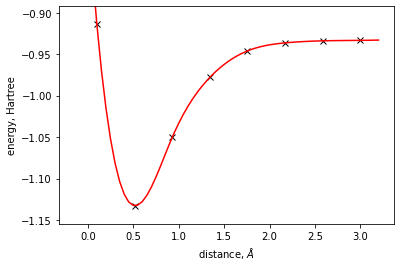

In [40]:
plt.plot(xdata, ydata, 'kx')
x = np.arange(min(xdata) - 0.25, max(xdata) + 0.25, 0.05)
plt.plot(x, energy_surface.eval(x), 'r-')
plt.xlabel(r'distance, $\AA$')
plt.ylabel('energy, Hartree')
dist = max(ydata) - min(ydata)
plt.ylim(min(ydata) - 0.1 * dist, max(ydata) + 0.1 * dist)

The Born-Oppeheimer approximation removes internuclear vibations from the molecular Hamiltonian and the energy computed from quantum mechanical ground-state energy calculations using this approximation contain only the electronic energy. Since even at absolute zero internuclear vibrations still occur, a correction is required to obtain the true zero-temperature energy of a molecule. This correction is called the zero-point vibrational energy (ZPE), which is computed by summing the contribution from internuclear vibrational modes. Therefore, the next step in computing thermodynamic observables is determining the vibrational energy levels. This can be done by constructing the Hessian matrix based on computed single point energies close to the equilibrium bond length. The eigenvalues of the Hessian matrix can then be used to determine the vibrational energy levels and the zero-point vibrational energy 	
\begin{equation}
{\rm ZPE} = \frac{1}{2}\, \sum_i ^M \nu_i \, ,
\end{equation}
with $\nu_i$ being the vibrational frequencies, $M = 3N − 6$ or $M = 3N − 5$ for non-linear or linear molecules, respectively, and $N$ is number of the particles.  

In [ ]:
#1. Fit a "full" energy surface using a 1D spline potential and
#    use it to evaluate molecular vibrational energy levels.

vibronic_structure = VibronicStructure1DFD(mol, energy_surface)

print(energy_surface.eval(energy_surface.get_equilibrium_geometry()))

# 1b. Plot the vibrational energy levels on the same figure.
for N in range(15):
    on = np.ones(x.shape)
    on *= (energy_surface.eval(energy_surface.get_equilibrium_geometry()) +
           vibronic_structure.vibrational_energy_level(N))
    plt.plot(x, on, 'g:')
on = np.ones(x.shape)

plt.show()


The partition function for a molecule is the product of contributions from translational, rotational, vibrational, electronic, and nuclear degrees of freedom. Having the vibrational frequencies, now we can obtain the vibrational partition function  $q_{\rm vibration}$ to compute the whole molecular partition function 
\begin{equation}
q_{\rm vibration} = \prod_{i=1} ^M \frac{\exp\,(-\Theta_{\nu_i}/2T)}{1-\exp\,(-\Theta_{\nu_i}/2T} \, . 
\end{equation} 
Here $\Theta_{\nu_i}= h\nu_i/k_B$, $T$ is the temperature and $k_B$ is the Boltzmann constant.  

The single-point energy calculations and the resulting partition function can be used to calculate the (constant volume or constant pressure) heat capacity of the molecules. The constant volume heat capacity, for example, is given by 

\begin{equation}
C_v = \left.\frac{\partial U}{\partial T}\right|_{N,V}\, ,
\qquad
{\rm with} \quad
U=k_B T^2 \left.\frac{\partial {\rm ln} Q}{\partial T}\right|_{N,V} .
\end{equation}

$U$ is the internal energy, $V$ is the volume and $Q$ is the partition function. 



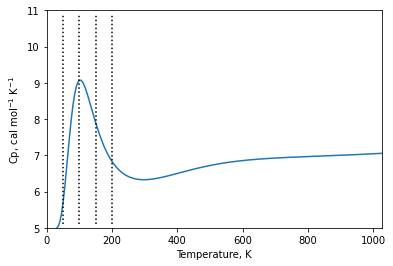

In [48]:
# 2. Create a partition function
import qiskit.chemistry.constants as const
from qiskit.chemistry.partition_function import DiatomicPartitionFunction
Q = DiatomicPartitionFunction(mol, energy_surface, vibronic_structure)

P = 101350  # Pa
temps = np.arange(10, 1050, 5)  # K

mol.spins = [1/2,1/2]
# 2a. Calculate Cp heat capacity
# Here we illustrate the simplest usage of the partition function,
# namely creating a Thermodynamics object to compute properties like
# the constant pressure heat capacity
from qiskit.chemistry.thermodynamics import Thermodynamics
td = Thermodynamics(Q, pressure = 101350)
td.set_pressure(101350)
temps = np.arange(10, 1500, 5)
ymin = 5
ymax = 11

plt.plot(temps,
         td.constant_pressure_heat_capacity(temps) / const.CAL_TO_J)
plt.plot([100, 100], [5.1, 10.9], "k:")
plt.plot([200, 200], [5.1, 10.9], "k:")
plt.plot([50, 50], [5.1, 10.9], "k:")
plt.plot([150, 150], [5.1, 10.9], "k:")
plt.xlim(0, 1025)
plt.ylim(ymin, ymax)
plt.xlabel('Temperature, K')
plt.ylabel('Cp, cal mol$^{-1}$ K$^{-1}$')

plt.show()

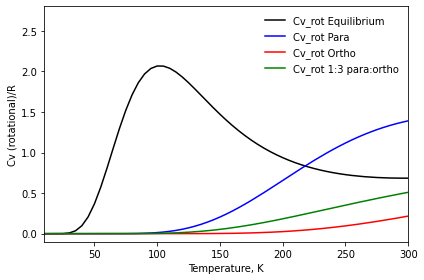

In [51]:
# 2b. Here we demonstrate how to access particular components
#   (the rotational part) of the partition function, which in the
#   H2 case we can further split to para-hydrogen and ortho-hydrogen
#   components.
eq = Q.get_partition(part="rot", split="eq")
para = Q.get_partition(part="rot", split="para")
ortho = Q.get_partition(part="rot", split="ortho")

# 2c. We will now plot the constant volume heat capacity (of the
#   rotational part) demonstrating how we can call directly
#   the functions in the 'thermodynamics' module, providing a
#   callable object for the partition function (or in this case
#   its rotational component).
HeatCapacity = constant_volume_heat_capacity

# We will normalize the plot dividing by the universal gas
#   constant R (Avogadro's number times Boltzman's constant).
R = const.N_A * const.KB_J_PER_K
plt.plot(temps,
         HeatCapacity(eq, temps) / R, '-k',
         label='Cv_rot Equilibrium')
plt.plot(temps, HeatCapacity(para, temps) / R, '-b',
         label='Cv_rot Para')
plt.plot(temps, HeatCapacity(ortho, temps) / R, '-r',
         label='Cv_rot Ortho')
plt.plot(temps, 0.25 * HeatCapacity(para, temps) / R
         + 0.75 * HeatCapacity(ortho, temps) / R, '-g',
         label='Cv_rot 1:3 para:ortho')
plt.legend(loc='upper right', framealpha=100, frameon=False)
plt.xlim(10, 300)
plt.ylim(-0.1, 2.8)
plt.xlabel('Temperature, K')
plt.ylabel('Cv (rotational)/R')
plt.tight_layout()
plt.show()
